In [1]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 58.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=e431bf57b5dc888a8a5c06a1f5ee270430246637cd7b35a2327d71a0c4fe737d
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy

In [2]:
import pretty_midi
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
def midi_to_notes(midi_file):
    try:
        midi = pretty_midi.PrettyMIDI(midi_file)
    except:
        return pd.DataFrame([])
    
    notes = collections.defaultdict(list)

    # Get the list of instrument program numbers
    program_numbers = np.arange(0,128)
    
    # One-hot encode the instrument program numbers
    num_instruments = len(program_numbers)
    one_hot_encoded_instruments = np.eye(num_instruments)
    
    # Create a dictionary mapping each instrument's program number to its one-hot encoded vector
    program_to_one_hot = {program: one_hot_encoded_instruments[i] for i, program in enumerate(program_numbers)}
    
    all_notes = []
    for instrument in midi.instruments:
        for note in instrument.notes:
            all_notes.append((note,instrument.program))
        
    sorted_notes = sorted(all_notes, key=lambda note: note[0].start)
    prev_start = sorted_notes[0][0].start

    for note_tuple in sorted_notes:
        note = note_tuple[0]
        program = note_tuple[1]
        start = note.start
        end = note.end
        # Append instrument data
        notes['instrument'].append(one_hot_encoded_instruments[program])
        notes['pitch'].append(one_hot_encoded_instruments[note.pitch])
        notes['start'].append(start)
        #print(start,end,program)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)

        prev_start = start

    return pd.DataFrame(notes)

In [4]:
def pre_process(notes, sequence_length=50):
    # Scale pitch values
    scaled_notes = notes.copy()  # Create a copy to avoid modifying the original array
    # scaled_notes[:,-3] /= 128 
    # Initialize input and output arrays
    
    n = len(scaled_notes)
    note_input = np.zeros((max(0, n - sequence_length), sequence_length, scaled_notes.shape[1]))
    note_output = np.zeros((max(0, n - sequence_length), scaled_notes.shape[1]))
    #print(note_input.shape,note_output.shape,scaled_notes.shape,scaled_notes[:sequence_length].shape)
    # Populate input and output arrays
    for i in range(n - sequence_length):
        note_input[i] = scaled_notes[i:i + sequence_length]
        note_output[i] = scaled_notes[i + sequence_length]
    
    return note_input, note_output

In [5]:
import random

files = []
for dirname, _, filenames in os.walk('/kaggle/input/musicnet-dataset/musicnet_midis/musicnet_midis'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
random.shuffle(files)

In [6]:
files[0]

'/kaggle/input/musicnet-dataset/musicnet_midis/musicnet_midis/Schubert/1734_sy_sps93.mid'

In [7]:
def fetch_files(n,files,num_files):
    start = n % len(files)
    end = min(len(files),n+num_files)
    all_notes = []
    for file in files[start:end]:
        notes = midi_to_notes(file)
        all_notes.append(notes)
    all_notes = pd.concat(all_notes)

    #key_order = ['instrument','pitch', 'step', 'duration']
    key_order = ['pitch', 'step', 'duration']
    try:
        train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
    except:
        return [],[]
    train_notes = train_notes.tolist()
    for i,train_note in enumerate(train_notes):
        train_notes[i] = np.concatenate((train_notes[i][0],train_notes[i][1:]))

    train_notes = np.array(train_notes)
    #print(type(train_notes))

    del all_notes
    #print(train_notes[15:20],"\nLength is: ",len(train_notes))

    note_input,note_output = pre_process(train_notes)
    del train_notes
    return note_input, note_output
    #print(note_input[0],"\nOUTPUT:\n",note_output[0])

In [8]:
def accuracy(model,test_loader):
    model.eval()
    correct_instruments = 0
    total_instruments = 0
    correct_pitch = 0
    total_pitch = 0
    loss_step = 0
    loss_duration = 0
    i = 0

    # Calculate accuracy for instruments
    for inputs, targets in test_loader:

        predictions = model(inputs)

        #_, predicted_instruments = predictions[:, :128].max(dim=1)
        #_, target_instruments = targets[:, :128].max(dim=1)
        #_, predicted_pitch = predictions[:, 128:256].max(dim=1)
        #_, target_pitch = targets[:, 128:256].max(dim=1)
        _, predicted_pitch = predictions[:, :128].max(dim=1)
        _, target_pitch = targets[:, :128].max(dim=1) 
        predicted_step = predictions[:, -2]
        target_step = targets[:, -2]
        predicted_duration = predictions[:, -1]
        target_duration = targets[:, -1]
        #predicted_pitch = (predictions[:, 128] * 128).int()
        #target_pitch = (targets[:, 128] * 128).int()
        #if(i<1):
            #print(predictions[0],"\n\n",target_instruments)
            #print(predicted_pitch,"\n\n",target_pitch)
        i+=1
        #correct_instruments += torch.sum(predicted_instruments == target_instruments).item()
        #total_instruments += target_instruments.size(0)
        correct_pitch += torch.sum(predicted_pitch == target_pitch).item()
        total_pitch += target_pitch.size(0)
        loss_step += F.l1_loss(predicted_step, target_step)
        loss_duration += F.l1_loss(predicted_duration, target_duration)
        
    #accuracy_instruments = (correct_instruments / total_instruments)
    accuracy_pitch = (correct_pitch / total_pitch)
    
    # Overall accuracy
    #overall_accuracy = (correct_instruments + correct_pitch) / (total_instruments + total_pitch)

    #print(f'Accuracy for instruments: {accuracy_instruments:.2%}')
    #print(f'\tAccuracy for pitch: {accuracy_pitch:.2%}')
    #print(f'\tLoss for step: {loss_step/i:.2}')
    #print(f'\tLoss for duration: {loss_duration/i:.2}')
    return accuracy_pitch*100
    #print(f'Overall accuracy: {overall_accuracy:.2%}')

In [9]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
# import torch_xla.debug.metrics as met
# import torch_xla.distributed.data_parallel as dp
# import torch_xla.distributed.parallel_loader as pl
# import torch_xla.utils.utils as xu
# import torch_xla.core.xla_model as xm
# import torch_xla.distributed.xla_multiprocessing as xmp
# import torch_xla.test.test_utils as test_utils
#import torch_xla.core.xla_model as xm


class MusicGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.1):
        super(MusicGenerator, self).__init__()        
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=False)
        #self.dropout = nn.Dropout(p = 0.3)
        #self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=False)
        # Fully connected layers
        self.fcP = nn.Linear(hidden_size, output_size-2)
        self.reluP = nn.ReLU()
        self.fcS = nn.Linear(hidden_size, 1)
        self.reluS = nn.ReLU()
        self.fcD = nn.Linear(hidden_size,1)
        self.reluD = nn.ReLU()
        # Softmax layers for instrument and pitch predictions
        #self.softmax_instrument = nn.Softmax(dim=1)
        self.softmax_pitch = nn.Softmax(dim=1)
        
        self.init_weights()

    def init_weights(self):
        for layer in [self.fcP, self.fcS, self.fcD]:
            nn.init.xavier_normal_(layer.weight)
            nn.init.constant_(layer.bias, 0.0)
        
    def forward(self, x):
        # LSTM layers
        out, _ = self.lstm1(x)
        #out= self.dropout(out)
        #out, _ = self.lstm2(out)
        #out, _ = self.lstm3(out)
        # Fully connected layers
        outP = self.fcP(out[:,-1,:])  # Take the last time step's output
        outP = self.reluP(outP)
        outS = self.fcS(out[:,-1,:])
        outS = self.reluS(outS)
        outD = self.fcD(out[:,-1,:])
        outD = self.reluD(outD)
        # Apply softmax to get probabilities for instrument prediction
        #instrument_probs = self.softmax_instrument(out[:, :128])
        # Apply softmax to get probabilities for pitch prediction
        pitch_probs = self.softmax_pitch(outP)

        # Keep step and duration as they are
        #step_duration = out[:, 256:]
        output = torch.cat((pitch_probs,outS,outD), dim=1)
        #output = pitch_probs
        #output = out
        
        return output

# Initialize your model
model = MusicGenerator(130,256,130)
#model = MusicGenerator(note_input.shape[2],256,130)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()
model.to(device)


MusicGenerator(
  (lstm1): LSTM(130, 256, num_layers=2, batch_first=True, dropout=0.1)
  (fcP): Linear(in_features=256, out_features=128, bias=True)
  (reluP): ReLU()
  (fcS): Linear(in_features=256, out_features=1, bias=True)
  (reluS): ReLU()
  (fcD): Linear(in_features=256, out_features=1, bias=True)
  (reluD): ReLU()
  (softmax_pitch): Softmax(dim=1)
)

In [10]:
torch.cuda.empty_cache()
print("\tInitial: ",torch.cuda.memory_allocated(),torch.cuda.memory_reserved())

	Initial:  3829248 23068672


In [11]:
import torch.nn.functional as F

class CustomWeightedLoss(nn.Module):
    def __init__(self, weights):
        super(CustomWeightedLoss, self).__init__()
        self.weights = weights

    def forward(self, predictions, targets):
        # Split the predictions and targets into pitch, step, and duration components
        pitch_pred, step_pred, duration_pred = predictions[:, :128], predictions[:, 128:129], predictions[:, 129:]
        pitch_target, step_target, duration_target = targets[:, :128], targets[:, 128:129], targets[:, 129:]

        # Compute the cross-entropy loss for the pitch prediction
        pitch_loss = F.binary_cross_entropy(pitch_pred, pitch_target)

        
        # Compute the mean squared error loss for step and duration predictions
        step_loss = F.l1_loss(step_pred, step_target)
        duration_loss = F.l1_loss(duration_pred, duration_target)

        # Apply weights to each loss component
        #print(pitch_loss,step_loss,duration_loss)
        weighted_pitch_loss = pitch_loss * self.weights[0]
        weighted_step_loss = step_loss * self.weights[1]
        weighted_duration_loss = duration_loss * self.weights[2]
        #print(weighted_pitch_loss,weighted_step_loss,weighted_duration_loss)

        #print(pitch_loss, step_loss, duration_loss)
        # Combine the weighted losses
        total_loss = weighted_pitch_loss + weighted_step_loss + weighted_duration_loss
        
        return total_loss

# Define your loss function and optimizer
weights = torch.tensor([20,10,10]).to(device)
#criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()
criterion = CustomWeightedLoss(weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
import matplotlib.pyplot as plt

class LossPlotter:
    def __init__(self,loss):
        self.fig, self.ax = plt.subplots()
        self.losses = list(loss)

    def update_plot(self, loss):
        self.losses.append(loss)
        self.ax.clear()
        self.ax.plot(self.losses, label='Loss')
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.legend()
        self.fig.canvas.draw()
        plt.pause(0.5)  # Pause to allow the plot to update

In [13]:
#TRAIN
num_epoch = 1
n = 0
pitch_accuracy = [0.00]
loss_value = []
#Loss_Plotter = LossPlotter(pitch_accuracy)
for i in range(num_epoch):
    torch.cuda.empty_cache()
    #print("\tInitial: ",torch.cuda.memory_allocated(),torch.cuda.memory_reserved())
    note_input,note_output = fetch_files(n,files,20)
    n += 20
    # Convert your data to PyTorch tensors (assuming you already have network_input and network_output)
    network_input_tensor = torch.tensor(note_input, dtype=torch.float32).to(device)
    network_output_tensor = torch.tensor(note_output, dtype=torch.float32).to(device)

    # Create a PyTorch dataset and data loader
    dataset = torch.utils.data.TensorDataset(network_input_tensor, network_output_tensor)
    del network_input_tensor
    del network_output_tensor
    # Define the size of the training and testing datasets
    test_size = 0.2  # You can adjust this as needed

    # Split the dataset into training and testing sets
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - int(len(dataset) * test_size), int(len(dataset) * test_size)])
    del dataset
    # Create data loaders for training and testing sets
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
    del train_dataset
    del test_dataset
    #print("\tBefore loop: ",torch.cuda.memory_allocated(),torch.cuda.memory_reserved())
    # Training loop    
    num_small_epochs = 200
    for epoch in range(num_small_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc=f'Epoch {i} Prev_accuracy {pitch_accuracy[-1]:.4} small_epoch {epoch+1}/{num_small_epochs}', leave=False):
        #for inputs, targets in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            
            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()       
            optimizer.step()
            # Accumulate the loss
            running_loss += loss.item()
        #print("\tAfter loop: ",torch.cuda.memory_allocated(),torch.cuda.memory_reserved())

        # Print the average loss for the epoch
        #print(f'Epoch [{epoch+1}/{num_small_epochs}], Loss: {running_loss / len(train_loader)}')
        #print("Testing Accuracy")
        #print(accuracy(test_loader),"%")
        loss_value.append(running_loss/len(train_loader))
        accuracy_value = accuracy(model,train_loader)
        pitch_accuracy.append(accuracy_value)
        torch.save(model.state_dict(), '/kaggle/working/model_parameters.pth')
        #Loss_Plotter.update_plot(accuracy_value)

    del train_loader,test_loader

/opt/conda/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


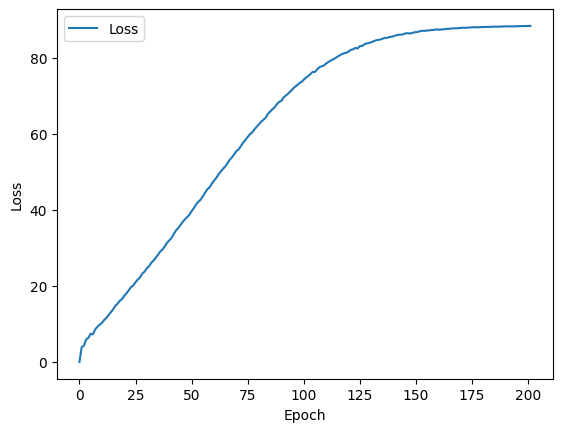

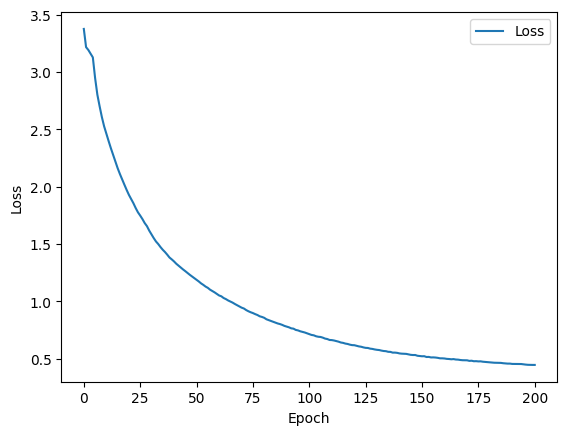

In [14]:
Loss_Plotter = LossPlotter(pitch_accuracy)
Loss_Plotter.update_plot(pitch_accuracy[-1])
Loss_Plotter2 = LossPlotter(loss_value)
Loss_Plotter2.update_plot(loss_value[-1])
#torch.save(model.state_dict(), 'model.pth')

In [15]:
torch.save(model.state_dict(), '/kaggle/working/parameters.pth')

In [16]:
model.load_state_dict(torch.load('/kaggle/working/parameters.pth'))

<All keys matched successfully>

**TESTING WITH ANOTHER MUSIC**

In [17]:
file_name = ["/kaggle/input/musicnet-dataset/musicnet_midis/musicnet_midis/Brahms/2127_bra11-2.mid"]
note_input_test,note_output_test = fetch_files(n,[files[random.randint(21,100)]],1)

network_input_test_tensor = torch.tensor(note_input_test, dtype=torch.float32).to(device)
network_output_test_tensor = torch.tensor(note_output_test, dtype=torch.float32).to(device)

In [18]:
def notes_to_midi(notes, output_file):

    midi_data = pretty_midi.PrettyMIDI()
    
    instruments_dict = {}

    prev_start = 0
    for note in notes:
        #instrument_number = note['instrument']
        #_, instrument_number = note[:128].max(dim=0)
        instrument_number = 0
        #print(instrument_number)
        instrument_number = int(instrument_number)
        
        if instrument_number not in instruments_dict:
            instruments_dict[instrument_number] = pretty_midi.Instrument(program=instrument_number)
        
        # Get the Instrument object from the dictionary
        instrument = instruments_dict[instrument_number]

        # Extract pitch, step, and duration from the note
        _, pitch = note[:128].max(dim=0)
        #pitch = note[-3]
        step = note[-2]
        #step = 0.4
        duration = note[-1]
        #duration = 0.3
        
        # Calculate start time and end time based on step and duration
        start_time = prev_start + step
        end_time = start_time + duration
        prev_start = start_time

        # Create a Note object and add it to the Instrument
        midi_note = pretty_midi.Note(
            velocity=100,  # Adjust the velocity (volume) of the note here if needed
            pitch=int(pitch),
            start=float(start_time),
            end=float(end_time)
        )
        #print(midi_note, start_time, end_time)
        instrument.notes.append(midi_note)

    # Add all instruments to the PrettyMIDI object
    for instrument_number, instrument in instruments_dict.items():
        midi_data.instruments.append(instrument)

    # Write the MIDI data to a file
    midi_data.write(output_file)

In [19]:
def generate_notes(model, initial_notes, num_notes_to_generate):
      
    generated_notes = initial_notes.clone().to(device)
    model.eval()
    
    with torch.no_grad():  # Disable gradient calculation since we're only predicting
        for _ in range(num_notes_to_generate):
            #print(generated_notes.shape)
            input_sequence = generated_notes[-50:].unsqueeze(dim=0)
            
            # Predict the next note
            predictions = model(input_sequence)
            #_, predicted_instruments = predictions[:, :128].max(dim=1)
            #_, predicted_pitch = predictions[:, 128:256].max(dim=1)          
            _, predicted_pitch = predictions.max(dim=1)
            # Append the predicted note to the generated sequence
            generated_notes = torch.cat((generated_notes, predictions), dim=0)
    
    return generated_notes 
generated_sequence = generate_notes(model, network_input_test_tensor[0], 200)

In [20]:
notes_to_midi(generated_sequence,"Fourth_Music.mid")